# Занятие 1. Введение в Машинное обучение

**Цель данного занятия** заключается в том, что бы научить вас работать с табличными данными с использованием модуля [pandas](https://pandas.pydata.org/), а также делать агрегаты и визуализировать их, что бы вы могли лучше понять природу тех данных, с которыми работаете.

Далее **загрузим таблицу** `articles.csv`, которая содержит информацию о статьях, опубликованных в различных изданиях. Для загрузки данных из csv-таблиц используется метод [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html). 

Заметим, что с помошью данного модуля можно читать таблицы, сохранённые в [других форматах](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html).

In [58]:
import pandas as pd

articles = pd.read_csv('articles.csv')

In [59]:
articles.head()

,id,title,publication,author,date,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,"SEOUL, South Korea — North Korea’s leader, ..."


Размер таблицы можно узнать, обратившись к полю [shape](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shape.html). 

In [60]:
articles.shape

(50000, 6)

Количество строк можно узнать применив функцию `len`.

In [61]:
num_rows = len(articles)
print(f'В таблицы содержится {num_rows} записей')

В таблицы содержится 50000 записей


**Часто в данных встречаются пропуски**, а нам нужно получить таблицу без пропусков, что бы в дальнейшем применять к ней алгоритмы машинного обучения.

Существуют различные стратегии борьбы с пропусками в данных. Наиболее простыми подходами являются:

*    Игнорирование объектов с пропущенными значениями

> Такой метод применим только в том случае, когда малая часть объектов выборки имеет пропущенные значения. Преимуществом данного подхода является простота и невозможность испортить данные путем замены пропусков.


*    Замена специальным значением

> Другим простейшим методом является замена пропусков на специальное заранее
определенное значение такое, как, например, 0 или -1. Данный подход позволяет не уменьшать размер выборки, однако может вносить значения, сильно отличающие от настоящих.

*    Замена самым частым или средним значением

> Данный метод, в отличие от двух предыдущих, учитывает имеющиеся данные и усредняет их.
 



Для начала посмотрим сколько всего пропущенных значений в каждом столбце, воспользовавшись методами [isna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isna.html) и [sum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sum.html).

In [62]:
flags = articles.isna()
flags.sum() / num_rows

id             0.00000
title          0.00000
publication    0.00000
author         0.12612
date           0.00000
content        0.00000
dtype: float64

In [63]:
flags = flags.sum(axis=1).astype(bool)

Какой, из выше перечисленной, стратегией мы можем воспользоваться в данном случае?

Удаляя строки, содержащие пропуски мы потеряем примерно 13% данных, но это самый быстрый способ и поэтому посмотрим, как это делается. 

Удалить строки с пропущенными значениями можно с помощью метода [dropna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html).


In [64]:
short_articles = articles.dropna()

print(f'В таблицы содержится {len(short_articles)} записей')

В таблицы содержится 43694 записей


Что бы заменить пропуски наиболее частотным автором, то сначала нужно понять, какой автор чаще всего публикуется. Для этого посчитаем количество публикаций каждого автора с помощью метода [value_counts](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.value_counts.html).

In [65]:
authors = short_articles['author'].value_counts()

authors[:10]

Breitbart News      1559
Pam Key             1282
Charlie Spiering     928
Jerome Hudson        806
John Hayward         747
Daniel Nussbaum      735
AWR Hawkins          720
Ian Hanchett         647
Joel B. Pollak       624
Alex Swoyer          604
Name: author, dtype: int64

In [66]:
print(f'Всего {len(authors)} уникальных авторов')

Всего 3603 уникальных авторов


Посмотрим на список всех авторов с конца.





In [ ]:
print('\n'.join(authors.index[::-1]))

Заметим, что часто в таблицы указан ни один автор, а несколько. 

Тогда мы можем разбить строки на последовательности авторов. Для этого реализуем следующую функцию:


In [68]:
from itertools import chain

def split_authors(string, separators=[', ', ' and ', ' &amp ']):
  authors = [string]
  
  for separator in separators:
    authors = list(chain(*[author.split(separator) for author in authors if author]))

  return authors

split_authors('Jeremy W. Peters, Alexandra Alter and Michael M. Grynbaum')

['Jeremy W. Peters', 'Alexandra Alter', 'Michael M. Grynbaum']

In [69]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

authors = short_articles['author'].apply(split_authors)
authors = mlb.fit_transform(authors)

authors = pd.DataFrame(authors, columns=mlb.classes_)
authors.head()

,,<strong>Amanda Davies</strong>,AJ Willingham,Alexandra King,Alisha Haridasani,Amanda Davies,Common Sense News,Danielle Rossingh,Faith Haleh Robinson,Faith Karimi,Faith Karimi,Jacopo Prisco,Joshua Berlinger,"Kara Fox,",Michael Martinez,"Michael Martinez,",Patrick Oppmann,Ravi Ubha,Ray Sanchez,Sara Ganim,Shachar Peled,Sophie Eastaugh,Stephy Chung,The Hollywood Reporter,Tiffany Ap,Wilfred Chan,<strong></strong>Allyssia Alleyne,"<strong></strong>Ashley Killough,<strong></strong>",<strong></strong>Ashley Killough<strong></strong>,<strong></strong>Drew Griffin<strong></strong>,<strong></strong>Ivan Watson,<strong></strong>Madison Park,"<strong></strong>Neil Curry,<strong></strong>","<strong></strong>Phoebe Parke,<strong></strong>",<strong></strong>Susan Candiotti,<strong>Allyssia Alleyne</strong>,<strong>Avery Wallace</strong>,<strong>Drew Griffin<strong></strong></strong>,<strong>Jack Forster<strong></strong></strong>,<strong>Jake Wallis Simons</strong>,...,Will Lloyd,Will Ripley,William Bigelow,William C. Rhoden,William D. Cohan,William Fierman,William Gibson,William Grimes,William J. Broad,William K. Rashbaum,William L. Hamilton,William McDonald,William Neuman,Willie Soon,Winnie Hu,Wolf Blitzer,Yamiche Alcindor,Yascha Mounk,Yasmeen Serhan,Yemisi Adegoke,Yemisi Adegoke,Yonette Joseph,Yotam Ottolenghi,Yu Han,Z. Byron Wolf,Zach D. Huff,Zach Dasher,Zach Montague,Zach Schonbrun,Zach Wichter,Zachary Cohen,Zachary Woolfe,Zahra Jamshed,Zahra Nader,Zahra Ullah,Zia ur-Rehman,and Charlie Nash,for CNN,Áine Cain,Óscar Martínez
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Заметим, что имя `Amanda Davies` встречается несколько раз и различаются только лишними тегами.

In [70]:
authors.columns[authors.columns.map(lambda x: 'Davies' in x)].tolist()

[' <strong>Amanda Davies</strong>', ' Amanda Davies ']

Следует почистить имена авторов. Для этого реализуем следующую функцию:


In [71]:
def clean_author(string, characters=['<strong>', '</strong>', '<sub>', '</sub>']):
  for character in characters:
    string = string.replace(character, '')

  return string.strip()

clean_author(' <strong>Amanda Davies</strong>')

'Amanda Davies'

In [72]:
authors = short_articles['author'].apply(clean_author).apply(split_authors)
authors = mlb.fit_transform(authors)

authors = pd.DataFrame(authors, columns=mlb.classes_, index=short_articles.index)
authors.head()

,A. O. Scott,A.O. Scott,AFP,AJ Willingham,AP,AWR Hawkins,Aaron E. Carroll,Aaron Klein,Aaron Manaigo,Abby Ellin,Abby Goodnough,Abby Jackson,Abigail Tucker,Adam Bienkov,Adam Chandler,Adam Glanzman,Adam Goldman,Adam Kirsch,Adam Levy,Adam Liptak,Adam Nagourney,Adam Nossiter,Adam Payne,Adam Pearce,Adam Popescu,Adam Serwer,Adam Shaw,Adam Wu,Adam Zagoria,Adeel Hassan,Adelle Nazarian,Adrienne Ross,Agustin Armendariz,Ai Weiwei,Aimee Lewis,Akin Oyedele,Al Baker,Al Goodman,Alain de Botton,Alan Blinder,...,Will Heilpern,Will Lloyd,Will Ripley,William Bigelow,William C. Rhoden,William D. Cohan,William Fierman,William Gibson,William Grimes,William J. Broad,William K. Rashbaum,William L. Hamilton,William McDonald,William Neuman,Willie Soon,Winnie Hu,Wolf Blitzer,Yamiche Alcindor,Yascha Mounk,Yasmeen Serhan,Yemisi Adegoke,Yonette Joseph,Yotam Ottolenghi,Yu Han,Z. Byron Wolf,Zach D. Huff,Zach Dasher,Zach Montague,Zach Schonbrun,Zach Wichter,Zachary Cohen,Zachary Woolfe,Zahra Jamshed,Zahra Nader,Zahra Ullah,Zia ur-Rehman,and Charlie Nash,for CNN,Áine Cain,Óscar Martínez
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [73]:
print(f'В таблицы содержится {len(authors)} записей')

В таблицы содержится 43694 записей


Как видно, можно и дальше продолжать чистить имена авторов, например используя [регулярные выражения](https://docs.python.org/3/library/re.html). Но нам важно, что мы смогли сократить количество уникальных авторов на треть.

In [74]:
authors.sum().sort_values(ascending=False)[:10]

Breitbart News      1567
Pam Key             1282
Charlie Spiering     929
Jerome Hudson        818
John Hayward         751
Daniel Nussbaum      741
AWR Hawkins          721
Ian Hanchett         647
Joel B. Pollak       630
Alex Swoyer          610
dtype: int64

Далее более дитально проанализируем данные, содержащиеся в таблицы, и возможно найдём более "правдоподобный" способ востановить пропущенных авторов.

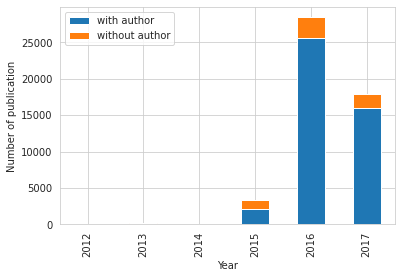

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

sns.set_style("whitegrid")

articles['year'] = articles['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)

publications = articles[~flags]['year'].value_counts()
publications.name = 'with author'

no_author_publications = articles[flags]['year'].value_counts()
no_author_publications.name = 'without author'

publications = publications.to_frame().join(no_author_publications).sort_index()

publications.plot.bar(stacked=True)
plt.ylabel('Number of publication')
plt.xlabel('Year')
plt.show()

Видим, что до 2015ого года в таблицы содержится очень малое, количество публикаций. 

Поэтому далее будем работать только с тремя последними годами.

In [76]:
articles = articles[articles['year'] >= 2015]

In [77]:
short_articles['year'] = short_articles['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)

flags = short_articles['year'] >= 2015

short_articles = short_articles[flags]
authors = authors[flags]

С помощью метода [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) удобно группировать данные по значениям одной или нескольких колонок. Далее можно вычислять различные статистики для каждой группы по отдельности.

Найдём наиболее публикуемого автора для каждого года.

In [78]:
publications = authors.join(short_articles['year']).groupby('year').sum()
publications

,A. O. Scott,A.O. Scott,AFP,AJ Willingham,AP,AWR Hawkins,Aaron E. Carroll,Aaron Klein,Aaron Manaigo,Abby Ellin,Abby Goodnough,Abby Jackson,Abigail Tucker,Adam Bienkov,Adam Chandler,Adam Glanzman,Adam Goldman,Adam Kirsch,Adam Levy,Adam Liptak,Adam Nagourney,Adam Nossiter,Adam Payne,Adam Pearce,Adam Popescu,Adam Serwer,Adam Shaw,Adam Wu,Adam Zagoria,Adeel Hassan,Adelle Nazarian,Adrienne Ross,Agustin Armendariz,Ai Weiwei,Aimee Lewis,Akin Oyedele,Al Baker,Al Goodman,Alain de Botton,Alan Blinder,...,Will Heilpern,Will Lloyd,Will Ripley,William Bigelow,William C. Rhoden,William D. Cohan,William Fierman,William Gibson,William Grimes,William J. Broad,William K. Rashbaum,William L. Hamilton,William McDonald,William Neuman,Willie Soon,Winnie Hu,Wolf Blitzer,Yamiche Alcindor,Yascha Mounk,Yasmeen Serhan,Yemisi Adegoke,Yonette Joseph,Yotam Ottolenghi,Yu Han,Z. Byron Wolf,Zach D. Huff,Zach Dasher,Zach Montague,Zach Schonbrun,Zach Wichter,Zachary Cohen,Zachary Woolfe,Zahra Jamshed,Zahra Nader,Zahra Ullah,Zia ur-Rehman,and Charlie Nash,for CNN,Áine Cain,Óscar Martínez
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015,0,0,0,0,1,3,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,...,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0
2016,12,1,71,0,37,526,5,242,1,0,7,54,0,0,0,0,13,0,0,28,11,2,0,2,1,0,0,0,1,3,157,1,0,1,0,44,5,0,0,35,...,2,0,1,33,2,0,6,1,7,2,3,2,1,5,0,6,0,24,1,1,0,1,0,1,0,2,1,1,2,1,1,2,2,2,1,1,0,0,5,1
2017,7,3,2,10,19,192,5,113,0,3,9,8,1,1,1,1,29,1,0,27,8,14,2,0,0,1,42,3,1,2,86,1,1,0,3,12,12,0,1,37,...,0,1,7,0,0,1,0,0,7,5,10,1,2,2,1,6,0,18,0,0,2,1,1,0,8,0,0,0,6,1,20,1,3,3,0,0,1,2,3,0


In [79]:
publications.idxmax(axis=1)

year
2015    Emanuella Grinberg
2016        Breitbart News
2017               Pam Key
dtype: object

Видим, что для разных годов, разные наиболее публикуемые авторы, а следовательно мы бы могли заполнить пропуски в изначальной таблицы учитывая год.

Далее посмотрим на распределение издательст и возможно придём к выводу, что сделует брать в расчёт и издательство.

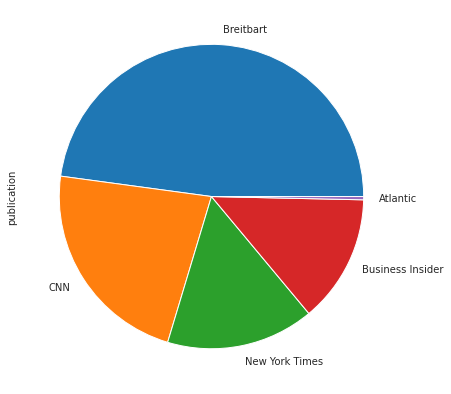

In [80]:
plt.figure(figsize=(7, 7))
articles['publication'].value_counts().plot.pie()
plt.show()

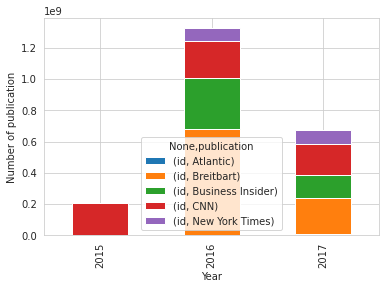

In [81]:
articles.groupby(['year', 'publication']).sum().unstack().plot.bar(stacked=True)
plt.ylabel('Number of publication')
plt.xlabel('Year')
plt.show()

А давайте ещё изобразим распределение длин заголовков (title) статей для каждого издательства. 

Сначала нам нужно будет посчитать количество символов в каждом заголовке. Для датафреймов существуют методы работы со строковыми данными. Чтобы применить их, необходимо воспользоваться атрибутом `str`, после чего вызвать нужные методы работы со строками. Например, вызов:

```df['content'].str.len() ```

подсчитает для каждой строчки в датафрейме количество символов в колонке content. Более подробную информацию про работу с текстовыми данными можно найти [здесь](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html).


Для визуализации можно воспользоваться, например, функцией [sns.violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html).

In [82]:
articles['len_title'] = articles['title'].str.len()

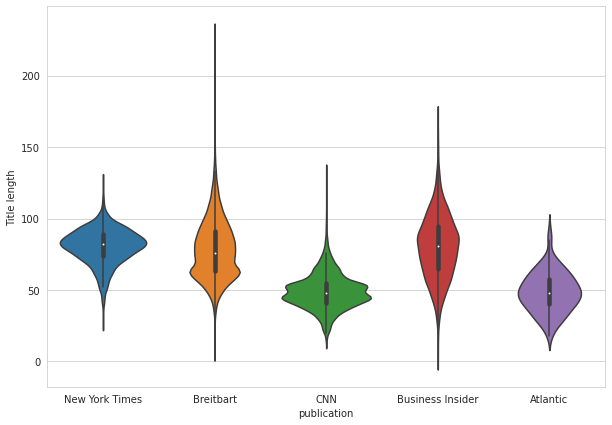

In [83]:
plt.figure(figsize=(10, 7))
sns.violinplot(x='publication', y='len_title', data=articles)
plt.ylabel('Title length')
plt.show()

# Лабораторная работа 0

Далее вы можете самостоятельно поработать с одним из четырёх датасетов, на выбор:

**Netflix Movies and TV Shows**

Таблица `netflix.csv` содержит следующую информацию о телешоу и фильмах, доступных на Netflix:

*   `show_id`: идентификатор телешоу или фильма
*   `type`: содержит значения TV Show или Movie
*   `title`: название
*   `director`: режиссёр
*   `cast`: список актёров
*   `country`: страна
*   `date_added`: дата добавления на Netflix
*   `release_year`: дата выхода
*   `rating`: рейтинг
*   `duration`: продолжительность

**COVID-19 World Vaccination Progress** 

Таблица `country_vaccinations.csv` содержит следующую информацию о вакцинации: 

*   `country`: страна
*   `iso_code`: ISO код страны
*   `date`: дата ввода данных
*   `total_vaccinations`: абсолютное количество прививок в стране
*   `people_vaccinated`: человек, в зависимости от схемы иммунизации, получит одну или несколько (обычно 2) вакцины
*   `people_fully_vaccinated`: количество людей, получивших полный набор прививок согласно схеме иммунизации (обычно 2)
*   `daily_vaccinations_raw`: количество вакцинаций на эту дату
*   `daily_vaccinations`: количество вакцинаций на эту дату
*   `total_vaccinations_per_hundred`: соотношение (в процентах) между количеством вакцинированных и общей численностью населения на текущий момент в стране
*   `people_vaccinated_per_hundred`: соотношение (в процентах) между иммунизированным населением и общей численностью населения на данный момент в стране

**HR Analytics: Job Change of Data Scientists**

Таблица `hr.csv` содержит следующую информацию о сотрудниках, которые прошли обучение в компании:

*   `enrollee_id`: идентификатор сотрудника
*   `city`: идентификатор города
*   `city_development_index`: индекс города
*   `gender`: пол
*   `relevent_experience`: релевантный опыт
*   `enrolled_university`: тип курса, если таковой имеется
*   `education_level`: уровень образования
*   `major_discipline`: основная дисциплина
*   `experience`: общий опыт работы
*   `company_size`: размер компании

**Credit Card customers**

Таблица `credit_card.csv` содержит следующую информацию о кредитных картах:

*   `CLIENTNUM`: уникальный идентификатор клиента, владеющего счетом
*   `Attrition_Flag`: если счет закрыт, то 1 иначе 0
*   `Customer_Age`: возраст
*   `Gender`: пол
*   `Dependent_count`: количество иждивенцев
*   `Education_Level`: уровень образования
*   `Marital_Status`: семейное положение
*   `Income_Category`: годовой доход
*   `Card_Category`: тип карты
*   `Months_on_book`: период взаимодействия с банком


**Правила выполнения**, соблюдение, которых позволит вам получить дополнительные баллы:

*   Выполнение данной лабораторной предполагает **работу в команде**. Следовательно, студент без команды не может получить оценку за неё. Команда должна содержать **от 2-х до 5-ти человек**.
*   После того, как вы сформировали команду и выбрали капитана. Капитан должен отправить в задание "Лабораторная работа 0" сообщение со списком членов своей команды, после чего состав команды менять нельзя.
*   Далее вы выбираете один из датасетов и начинаете его анализировать. Ваша задача сделать как можно больше выводов из данных, каждый вывод должен быть отдельно оформлен и подкреплён графиками.
*   После того, как вы исчерпали свои идеи, загружайте решение в задание "Лабораторная работа 0". Проверяется только решение, которое было загружено первым.
*   Если вы успели сделать задание за время семинара, то вы можете **увеличить баллы своей команды в 1.5 раза рассказав о проделанной работе остальным**.
*  В этом задании вы соревнуетесь с другими командами, которые выбрали тот же датасет. Максимальное число баллов, которое может получить каждый член команды за это задание 5 (без учёта надбавки за выступление).
*  После того, как все команды загрузили свои решения (**дедлайн 15 февраля 2021 09:00**), мы начинаем проверять ваши решения с тех команд, которые раньше его загрузили. Каждой команде мы засчитываем только те выводы, которых не было в решениях предыдущих команд. Количество засчитанных выводов делится на количество всех уникальных выводов, сделанных всеми командами. Затем максимальное число баллов умножается на данный коэффициент и получается ваша оценка, которая может быть домножена на 1.5, если вы выступили на семинаре.

**Пример**

Пусть в соревновании участвовали 2 команды. 

Первая команда сделала выводы 1, 2, 3 и выступила на семинаре. 

Вторая - сделала выводы 1, 2, 4, 5, 6, 7, 8 и загрузила своё решение после семинара. 

Тогда первая команда получит (3/8) * 5 * 1.5 ~ 2.8, а вторая (5/8) * 5 ~ 3.1 (второй команде не будут засчитаны выводы 1 и 2)
